In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
api_key = "02cd0c8a-8c17-4b6d-82c0-b7f4bc34a56f"


# url = "https://api.opendota.com/api/matches/6745683521?api_key="
# url = "https://api.opendota.com/api/heroStats?api_key="
# url = "https://api.opendota.com/api/publicMatches?api_key="

# resp = requests.get(url=url)
# data = json.loads(resp.content)
# matches  = pd.DataFrame(data)["match_id"].values

# drafts = []
# outcome = []

# for match in matches:
#     _query = f"https://api.opendota.com/api/matches/{match}?api_key="
#     resp = requests.get(_query)
#     assert resp.ok
#     data = json.loads(resp.content)
#     drafts.append(data["picks_bans"])
#     outcome.append(int(data["radiant_win"]*1.0))
#     time.sleep(1)

# import numpy as np

# def process_raw_drafts(raw_draft):
#     """
#     Takes raw draft data and givens 2 arrays, one with radiant's draft
#     and the other with dire's
#     """

#     draft_radiant = [_d["hero_id"] for _d in raw_draft if _d["is_pick"] and not _d["team"]]
#     draft_dire = [_d["hero_id"] for _d in raw_draft if _d["is_pick"] and _d["team"]]

#     return np.array(draft_radiant + draft_dire)

In [3]:
# download basic hero stats that we can use for embedding

_hero_embedding_query = "https://api.opendota.com/api/heroStats?api_key="
resp = requests.get(_hero_embedding_query)
assert resp.ok
stats = pd.DataFrame(json.loads(resp.content)).set_index("id")

In [4]:
stats.columns

Index(['name', 'localized_name', 'primary_attr', 'attack_type', 'roles', 'img',
       'icon', 'base_health', 'base_health_regen', 'base_mana',
       'base_mana_regen', 'base_armor', 'base_mr', 'base_attack_min',
       'base_attack_max', 'base_str', 'base_agi', 'base_int', 'str_gain',
       'agi_gain', 'int_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'cm_enabled', 'legs',
       'hero_id', 'turbo_picks', 'turbo_wins', 'pro_ban', 'pro_win',
       'pro_pick', '1_pick', '1_win', '2_pick', '2_win', '3_pick', '3_win',
       '4_pick', '4_win', '5_pick', '5_win', '6_pick', '6_win', '7_pick',
       '7_win', '8_pick', '8_win', 'null_pick', 'null_win'],
      dtype='object')

In [5]:
# get roles embedding for each hero
roles_encoding = stats["roles"].str.join("|").str.get_dummies()
roles_encoding

,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
id,,,,,,,,,
1,1,0,0,1,0,0,1,0,0
2,1,1,1,0,1,1,0,0,0
3,0,1,1,0,0,0,1,0,1
4,1,1,0,0,1,1,1,0,0
5,0,1,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...
128,0,1,0,1,0,0,1,0,1
129,1,1,1,0,1,0,0,0,0
135,1,0,1,0,0,0,0,0,0


In [6]:
# basic embedding: roles + attack_type + primary_attribute

embedding = pd.concat([pd.get_dummies(stats[["attack_type", "primary_attr"]]), roles_encoding], axis = 1).reset_index(drop=True)
embedding  # we have our embedding

,attack_type_Melee,attack_type_Ranged,primary_attr_agi,primary_attr_int,primary_attr_str,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
0,1,0,1,0,0,1,0,0,1,0,0,1,0,0
1,1,0,0,0,1,1,1,1,0,1,1,0,0,0
2,0,1,0,1,0,0,1,1,0,0,0,1,0,1
3,1,0,1,0,0,1,1,0,0,1,1,1,0,0
4,0,1,0,1,0,0,1,0,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,1,0,0,1,0,1,0,1,0,0,1,0,1
119,1,0,0,0,1,1,1,1,0,1,0,0,0,0
120,1,0,0,0,1,1,0,1,0,0,0,0,0,0
121,1,0,0,0,1,1,1,0,1,1,0,0,0,1


In [7]:
# load in dataset of drafts match outcomes

dataset = pd.read_pickle("dota.pickle")
radiant_win, radiant_draft, dire_draft, _, _, num_matches, num_heroes = dataset

In [8]:
heroes_list = np.unique(np.concatenate([radiant_draft, dire_draft], axis=0).flatten())
embedding = embedding.loc[np.arange(num_heroes)].values

# build the draft vector described in paper, a (num_heroes x 1) vector with +1 in the ith entry if the ith hero is picked by radiant, -1 if picked by the dire, 0 otherwise.
drafts = list()
empty_draft = np.zeros((num_heroes, ))

for idx in range(num_matches):
    temp = empty_draft.copy()
    temp[radiant_draft[idx]] = 1
    temp[dire_draft[idx]] = -1

    drafts.append(temp)

drafts = np.asarray(drafts, dtype=np.int64)

# our dataset of drafts
assert drafts.shape == (num_matches, num_heroes)

# embedding dataset for each match
K = drafts @ embedding

# combined datset, both embedding + hero indication
X = np.concatenate((K, drafts), axis=1)
assert X.shape == (num_matches, embedding.shape[1] + num_heroes)

y = radiant_win.copy()

In [9]:
# create train, val and test split
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(np.arange(num_matches), test_size=0.2, train_size=0.8, shuffle=True)
idx_train, idx_val = train_test_split(idx_train, train_size=0.75, test_size=0.25, shuffle=True)

# keep the split points for X and K the same
X_train, X_val, X_test = X[idx_train], X[idx_val], X[idx_test]
K_train, K_val, K_test = K[idx_train], K[idx_val], K[idx_test]
y_train, y_val, y_test = y[idx_train], y[idx_val], y[idx_test]


In [10]:
# fit benchmark Logistic Regression model with only embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

base_model = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1e6)
base_model.fit(K_train, y_train)

LogisticRegression(max_iter=1000000.0, penalty='l1', solver='liblinear')

In [11]:
print(f"Accuracy score for training datset: {accuracy_score(y_train, base_model.predict(K_train))}")
print(f"Accuracy score for validation datset: {accuracy_score(y_val, base_model.predict(K_val))}")

Accuracy score for training datset: 0.5574040176514499
Accuracy score for validation datset: 0.5585807082717861


In [23]:
# fit larger LR model with hero specific coefs

hero_model = LogisticRegression(penalty="l1", solver="liblinear")
hero_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [24]:
print(f"Accuracy score for training datset: {accuracy_score(y_train, hero_model.predict(X_train))}")
print(f"Accuracy score for validation datset: {accuracy_score(y_val, hero_model.predict(X_val))}")

Accuracy score for training datset: 0.6390749619538517
Accuracy score for validation datset: 0.6386354750956538


In [25]:
# adding hero specific features increases model accuracy by ~14%

In [27]:
# Try a deep neural network
"""
The motivation for a DNN is that we hope to to try and capture non-linear combinations of heroes
to improve performance. For example a DNN will allow us to try and find pairs or triplets of heroes
that have 'better than additive' synergy.
"""
import torch.nn as nn
import torch

feature_number = embedding.shape[1] + num_heroes

# class NeuralNetwork(nn.Module):
#     def __init__(self) -> None:
#         super().__init__()
        
#         self.network = nn.Sequential(
#             nn.Linear(feature_number, 200),
#             nn.ReLU(),
#             nn.Linear(200, 50),
#             nn.ReLU(),
#             nn.Linear(50, 1)
#             # nn.Softmax()
#         )
    
#     def forward(self, x):
#         return self.network(x).flatten()


class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Linear(feature_number, 40),
            nn.ReLU(),
            nn.Linear(40, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
            # nn.Softmax()
        )
    
    def forward(self, x):
        return self.network(x).flatten()

nn_model = NeuralNetwork()

In [28]:
# transfer our numpy data to torch tensors/dataloaders
from torch.utils.data import TensorDataset, DataLoader


TRAIN_BATCH_SIZE = 50
TEST_BATCH_SIZE = VAL_BATCH_SIZE = 10_000


X_train_tensor = torch.Tensor(X_train)
K_train_tensor = torch.Tensor(K_train)
y_train_tensor = torch.Tensor(y_train)

X_val_tensor = torch.Tensor(X_val)
K_val_tensor = torch.Tensor(K_val)
y_val_tensor = torch.Tensor(y_val)

X_test_tensor = torch.Tensor(X_test)
K_test_tensor = torch.Tensor(K_test)
y_test_tensor = torch.Tensor(y_test)

full_train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
full_val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
full_test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

test_dataloader = DataLoader(full_test_dataset, batch_size=TEST_BATCH_SIZE)
val_dataloader = DataLoader(full_val_dataset, batch_size=VAL_BATCH_SIZE)
train_dataloader = DataLoader(full_train_dataset, batch_size=TRAIN_BATCH_SIZE)

In [32]:
# define hyperparams, loss and optimizer

learning_rate = 5e-5
epochs = 1

loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(nn_model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(params=nn_model.parameters(), lr=1e-4)
# eval_fn = accuracy_score

In [33]:
from typing import NamedTuple

class TrainingResults(NamedTuple):
    train_evaluation_history: np.array
    validation_evaultation_history: np.array


def train_and_validation_loop(model, training_dataloader, validation_dataloader, loss_function, optimization_engine, evaluation_function) -> TrainingResults:
    size = len(training_dataloader.dataset)
    training_eval_history = list()
    for batch, (X, y) in enumerate(train_dataloader):
        pred = model(X)
        loss = loss_function(pred, y)

        optimization_engine.zero_grad()
        loss.backward()
        optimization_engine.step()

        if batch % 100 == 0:
            print(f"Step [{batch * len(X):>5d}/{size:>5d}]")

            # current training metrics
            pred = torch.sigmoid(pred) > 0.5
            eval_training = evaluation_function(y, pred)
            training_eval_history.append(eval_training)
            print(f"Training evaluation metric: {evaluation_function(y, pred):.2f}")
            print(f"Training loss: {loss.item():.2f}")
            
        if batch % 1000 == 0:
            # test on our validation dataset
            total_validation_accuracy = 0
            with torch.no_grad():
                for X_val, y_val in validation_dataloader:
                    pred_val = model(X_val)
                    pred_val = torch.sigmoid(pred_val) > 0.5
                    total_validation_accuracy += evaluation_function(y_val, pred_val)

            print(f"Validation evalutaion metric: {total_validation_accuracy / len(val_dataloader):.2f}")

    plt.plot(training_eval_history)
                

def torch_accuracy_score(y_true, y_pred):
    sum = torch.sum(y_true == y_pred).item()
    return sum / len(y_true)

Step [    0/1833957]
Training evaluation metric: 0.60
Training loss: 87.22
Validation evalutaion metric: 0.61
Step [ 5000/1833957]
Training evaluation metric: 0.62
Training loss: 103.21
Step [10000/1833957]
Training evaluation metric: 0.66
Training loss: 112.30
Step [15000/1833957]
Training evaluation metric: 0.58
Training loss: 105.28
Step [20000/1833957]
Training evaluation metric: 0.68
Training loss: 122.42
Step [25000/1833957]
Training evaluation metric: 0.70
Training loss: 115.10
Step [30000/1833957]
Training evaluation metric: 0.62
Training loss: 87.17
Step [35000/1833957]
Training evaluation metric: 0.52
Training loss: 93.84
Step [40000/1833957]
Training evaluation metric: 0.74
Training loss: 118.58
Step [45000/1833957]
Training evaluation metric: 0.70
Training loss: 120.01
Step [50000/1833957]
Training evaluation metric: 0.56
Training loss: 101.24
Validation evalutaion metric: 0.61
Step [55000/1833957]
Training evaluation metric: 0.68
Training loss: 124.61
Step [60000/1833957]


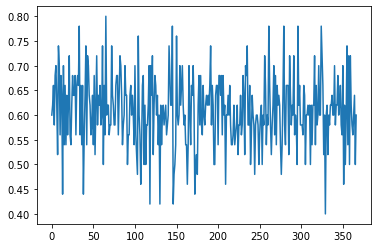

In [34]:
train_and_validation_loop(nn_model, train_dataloader, val_dataloader, loss_fn, optimizer, torch_accuracy_score)

In [130]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [131]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, nn_model, loss_fn, optimizer)
    test_loop(val_dataloader, nn_model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 620.119385  [    0/1833957]
loss: 630.280884  [20000/1833957]
loss: 524.894653  [40000/1833957]
loss: 593.669250  [60000/1833957]
loss: 571.914673  [80000/1833957]
loss: 588.110535  [100000/1833957]
loss: 513.986816  [120000/1833957]
loss: 603.819824  [140000/1833957]
loss: 599.019836  [160000/1833957]
loss: 583.026550  [180000/1833957]
loss: 551.539429  [200000/1833957]
loss: 593.872192  [220000/1833957]
loss: 588.486267  [240000/1833957]
loss: 514.005493  [260000/1833957]
loss: 576.875549  [280000/1833957]
loss: 540.469299  [300000/1833957]
loss: 599.091064  [320000/1833957]
loss: 620.141846  [340000/1833957]
loss: 556.705627  [360000/1833957]
loss: 545.881714  [380000/1833957]
loss: 582.870239  [400000/1833957]
loss: 593.069641  [420000/1833957]
loss: 540.596802  [440000/1833957]
loss: 567.101624  [460000/1833957]
loss: 577.834839  [480000/1833957]
loss: 556.476929  [500000/1833957]
loss: 620.127808  [520000/1833957]
loss: 534.875916  [5

KeyboardInterrupt: 

In [124]:
for batch, (X, y)  in enumerate(train_dataloader):
    break

In [127]:
y

tensor([1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
        0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        1., 1.])

In [128]:
nn_model.forward(X).flatten()

tensor([-0.1555, -0.1228, -0.1312, -0.1111, -0.0725, -0.1061, -0.1515, -0.1753,
        -0.1232, -0.1279, -0.1214, -0.1590, -0.1516, -0.1602, -0.1703, -0.1225,
        -0.1626, -0.1302, -0.1803, -0.1560, -0.1275, -0.1634, -0.1836, -0.1128,
        -0.1270, -0.1750, -0.1635, -0.1610, -0.1698, -0.1490, -0.1615, -0.1072,
        -0.1124, -0.1418, -0.1231, -0.2072, -0.1214, -0.0889, -0.1241, -0.1790,
        -0.1220, -0.1740, -0.1540, -0.1398, -0.1411, -0.1033, -0.1837, -0.0973,
        -0.1617, -0.1669, -0.1571, -0.1185, -0.1869, -0.1451, -0.1231, -0.1248,
        -0.1488, -0.1134, -0.1098, -0.1451, -0.1569, -0.1361, -0.1857, -0.1319,
        -0.0869, -0.1439, -0.1495, -0.1214, -0.1719, -0.1140, -0.1026, -0.1362,
        -0.1670, -0.1615, -0.1355, -0.1282, -0.1243, -0.1846, -0.1504, -0.1601,
        -0.1006, -0.1227, -0.1516, -0.1607, -0.1232, -0.1433, -0.1498, -0.1041,
        -0.1311, -0.1423, -0.1724, -0.1653, -0.1040, -0.1594, -0.1384, -0.1316,
        -0.1486, -0.1540, -0.1282, -0.14

In [125]:
loss_fn(nn_model.forward(X), y)

RuntimeError: expected scalar type Long but found Float

In [104]:
X.shape

torch.Size([200, 128])

In [105]:
y.shape

torch.Size([200])

In [118]:
nn_model.forward(X)

tensor([[-1.8912e-01, -5.7425e-02],
        [-1.5475e-01, -1.4809e-01],
        [-7.1998e-02, -1.5522e-01],
        [-1.0326e-01, -7.7930e-02],
        [-1.5057e-01, -2.9486e-02],
        [-9.6504e-02,  1.8674e-02],
        [-1.1713e-01, -1.1737e-02],
        [-7.7100e-02, -1.0176e-01],
        [-9.4819e-02,  9.2966e-03],
        [-9.7504e-02, -2.8424e-02],
        [-1.7037e-01, -8.6623e-02],
        [-1.0515e-01, -3.6761e-02],
        [-3.4627e-02, -9.0209e-02],
        [-5.1570e-02, -5.1420e-02],
        [-1.3527e-01, -6.6940e-02],
        [-1.2376e-01, -4.7756e-02],
        [-1.0255e-01, -5.1782e-02],
        [-8.6992e-02, -3.1702e-02],
        [-3.5523e-02, -8.6282e-02],
        [-8.8603e-02,  1.8601e-02],
        [-1.8063e-01, -1.1380e-01],
        [-8.4285e-02,  4.9493e-02],
        [-1.0022e-01, -3.1401e-02],
        [-1.0214e-01, -2.9818e-02],
        [-1.0784e-01, -3.4894e-02],
        [-1.8008e-01, -9.0804e-02],
        [-1.0357e-01, -1.0753e-01],
        [-1.2374e-01, -9.272